In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as ft
import numpy.ma as ma
from scipy import optimize
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
%matplotlib inline

In [2]:
#Open one file to view header info
test1 = ft.open('/Users/chloecheng/Documents/School/Undergrad/Third Year/Year/AST326/Lab 5/Lab5_ACAM_DATA/r1599688.fit')

In [3]:
#View the information in the header file 
test1.info()
test1['primary'].header

Filename: /Users/chloecheng/Documents/School/Undergrad/Third Year/Year/AST326/Lab 5/Lab5_ACAM_DATA/r1599688.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     125   ()      
  1  extension1    1 ImageHDU        49   (2148, 2071)   int16 (rescales to uint16)   


SIMPLE  =                    T /                                                
BITPIX  =                    8 /                                                
NAXIS   =                    0 /                                                
EXTEND  =                    T / File contains extensions                       
RUN     =              1599688 / Run number                                     
IRAFNAME= 'r1599688          ' / IRAF should use this name                      
RUNSET  = '10:60:1599679     ' / i:n:r => Run i of n runs starting at #r        
SYSVER  = 'S15-261           ' / Version of observing system                    
ORIGIN  = 'ING La Palma      ' / Name of observatory                            
OBSERVAT= 'LAPALMA           ' / Name of observatory (IRAF style)               
OBSERVER= 'de Mooij          ' / Name of principal investigator                 
PROPOSAL= 'N6                ' / Code for grant of observing time               
OBJECT  = 'GJ1214           

In [4]:
test1['extension1'].header

XTENSION= 'IMAGE   '           /                                                
BITPIX  =                   16 /                                                
NAXIS   =                    2 /                                                
NAXIS1  =                 2148 /                                                
NAXIS2  =                 2071 /                                                
PCOUNT  =                    0 / Number of pixels following data                
GCOUNT  =                    1 / Number of groups                               
BZERO   =       32768.00000000 / Pixel-data have 32K offset.                    
BSCALE  =           1.00000000 / Pixel-data are not scaled.                     
INHERIT =                    T / Extension inherits primary HDU.                
EXTNAME = 'extension1        ' / Extension name                                 
EXTVER  =                    1 / Extension version number                       
IMAGEID =                   

In [5]:
#Define fitting functions
def gauss(x, *p):
    A, mu, sigma, base = p
    return A*np.exp(-(x - mu)**2/(2.*sigma**2))+base

def gaussian(height, center_x, center_y, width_x, width_y):
	"""Returns a gaussian function with the given parameters"""
	width_x = float(width_x)
	width_y = float(width_y)
	return lambda x,y: height*np.exp(
            	-(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
	"""Returns (height, x, y, width_x, width_y)
	the gaussian parameters of a 2D distribution by calculating its
	moments """
	total = data.sum()
	X, Y = np.indices(data.shape)
	x = (X*data).sum()/total
	y = (Y*data).sum()/total
	col = data[:, int(y)]
	width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
	row = data[int(x), :]
	width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
	height = data.max()
	return height, x, y, width_x, width_y

def fitgaussian(data):
	"""Returns (height, x, y, width_x, width_y)
	the gaussian parameters of a 2D distribution found by a fit"""
	params = moments(data)
	errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                             	data)
	p, success = optimize.leastsq(errorfunction, params)
	return p

In [6]:
#Import all of the files
filenames = sorted(glob.glob('/Users/chloecheng/Documents/School/Undergrad/Third Year/Year/AST326/Lab \
5/Lab5_ACAM_DATA/r1*.fit'))

#Bring in first biases
bias1 = []
for filename in range(0,21):
    bias_file1 = ft.open(filenames[filename]) #Open the biases
    bias1_data = bias_file1['extension1'].data #Get the data
    bias1.append(bias1_data) #Append the data to the empty list
bias1 = np.array(bias1) #Turn the list into an array

#Bring in second biases
bias2 = []
for filename in range(431,458):
    bias_file2 = ft.open(filenames[filename]) #Open the biases
    bias2_data = bias_file2['extension1'].data #Get the data
    bias2.append(bias2_data) #Append the data to the empty list
bias2 = np.array(bias2)

#Combine bias files
all_bias = np.vstack((bias1[:,0:2071], bias2))

#Make master bias by finding the median
master_bias = (np.median(bias1[:,0:2071], axis=0) + np.median((bias2), axis=0))/2

#Bias 2 median
#bias2_median = np.median(bias2, axis=0)

In [85]:
#Calculate noise
#Dark current noise
dark_noise = np.sqrt(master_bias)

#Readout noise - rms of bias level
bias_no_median = all_bias - master_bias #subtract the median of the bias from the bias files
#Calculate the readout noise
readout_noise = []
for i in range(0, len(all_bias)):
    readout_noise.append(np.sqrt((1/len(all_bias))*(np.sum((bias_no_median[i])**2))))
readout_noise = np.array(readout_noise)

In [67]:
print(readout_noise.shape)

(48, 2071, 2148)


In [8]:
#Bring in first flats
flats1 = []
for filename in range(21,39):
    flat_file1 = ft.open(filenames[filename]) #Open flats
    flat1_data = flat_file1['extension1'].data #Get data
    flat1_median = np.median(flat1_data) #Take the median of the data
    flat1_divided = flat1_data/flat1_median #Normalize the flats
    flats1.append(flat1_divided) 
flats1 = np.array(flats1)

#Bring in second flats
flats2 = []
for filename in range(403,432):
    flat_file2 = ft.open(filenames[filename]) #Open flats
    flat2_data = flat_file2['extension1'].data #Get data
    flat2_median = np.median(flat2_data) #Take the median of the data
    flat2_divided = flat2_data/flat2_median #Normalize the flats
    flats2.append(flat2_divided)
flats2 = np.array(flats2)

#Combine flats
#all_flats = np.vstack((flats1, flats2))

#Take median to make master flat
#master_flat = np.median(all_flats, axis=0)

In [9]:
def normalizing_flats(data1, data2):
    'This finds the normalized flatfields for the before flats(data a) and the after flats (data b)'
    #Now compute the normalized flat field images
    nflatsb = np.zeros((18,2071,2148))
    length = [10,11,12,14,15,17,20,22,25,28,30,32]
    length_end = [30,28,26,24,20,18,15,10]
    for i in np.arange(12):
        nflatsb[i] = (data2[i]/length[i])/(np.median(data2[i]/length[i]))

    nflatsa = np.zeros((29,2071,2148))
    for i in np.arange(8):
        nflatsa[i] = (data1[i]/length_end[i])/(np.median(data1[i]/[length[i]]))
    return nflatsa, nflatsb

nflatsa,nflatsb = normalizing_flats(flats1, flats2)

#Average together the before and after flat fields and then divide by their median to get the master flat
master_flat = ((np.median(nflatsb, axis=0)+np.median(nflatsa, axis=0))/2) /np.median((np.median(nflatsb, axis=0)\
                                                                                      +np.median(nflatsa, axis=0))/2)

In [10]:
#Open exoplanet data and bring in timestamps
exoplanet_data = []
timestamps = []
for filename in range(39,403):
    exoplanet_file = ft.open(filenames[filename]) #Open the data
    exoplanet_dat = exoplanet_file['extension1'].data #Get the data
    exoplanet_data.append(exoplanet_dat)
    obs_time = exoplanet_file['primary'].header['utobs'] #Get the timestamps
    timestamps.append(obs_time)
exoplanet_data = np.array(exoplanet_data)
timestamps = np.array(timestamps) 

In [11]:
#Subtract biases and divide flats
corrected_exoplanet_data = np.zeros_like(exoplanet_data)
for i in range(0, 364):
    corrected_exoplanet_data[i] = (exoplanet_data[i] - master_bias)/master_flat

Masking

In [12]:
#Masking
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        #radius = min(center[0], center[1], w-center[0], h-center[1])
        radius = 980

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


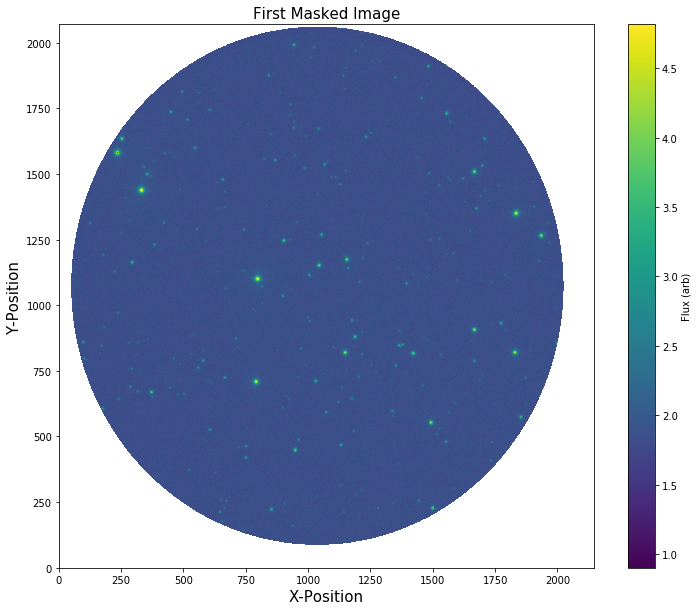

In [91]:
#Mask the first image
h0, w0 = corrected_exoplanet_data[0].shape[:2] #Get height and width data
mask0 = create_circular_mask(2071,2148, center=[1035,1074], radius=2071/2.1) #Create mask
masked_img0 = corrected_exoplanet_data[0].copy()
masked_final0 = masked_img0*(mask0) #Mask the data

#Plot to view
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(masked_final0), aspect='auto', origin='lower')
plt.title('First Masked Image', fontsize=15)
plt.xlabel('X-Position', fontsize=15)
plt.ylabel('Y-Position', fontsize=15)
plt.colorbar().set_label('Flux (arb)', rotation=90)
plt.savefig('masked1.pdf')

In [14]:
#Mask all images - mask should be the same for every image, so use mask0 from above
masked_final = np.zeros_like(corrected_exoplanet_data)
h = np.zeros(364)
w = np.zeros(364)

for i in range(0,364):
    h[i], w[i] = corrected_exoplanet_data[i].shape[:2]
    masked_imgs = corrected_exoplanet_data.copy
    masked_final[i] = corrected_exoplanet_data[i]*mask0

Find reference stars in the first frame:

In [21]:
#Find brightest points
bright = np.where((masked_final[0]) > 2000)

In [16]:
#Find the x-positions and y-positions of the brightest points such that the stars are of a certain size
xposition = []
tack = []
for i in range(len(bright[0])-1):
    if bright[0][i+1]-bright[0][i] <=1 and bright[1][i+1]-bright[1][i] <50:
        tack.append(bright[0][i])
        continue
    
    xposition.append(tack)
    tack = []

tick = []    
yposition = []
for i in range(len(bright[1])-1):
    if bright[0][i+1]-bright[0][i] <=1 and bright[1][i+1]-bright[1][i] <50:
        tick.append(bright[1][i])
        continue
    
    yposition.append(tick)
    tick = []

In [17]:
#Increase the size for reference stars to narrow the number 
x_tailored = []
y_tailored = []

for i in range(len(xposition)):
    if len(xposition[i]) >50:
        x_tailored.append(xposition[i])
        y_tailored.append(yposition[i])

In [25]:
#Calculate 2D Gaussian fits to find the centres of the stars within a box 
#Calculate the parameters for the fits
parameters = []
for i in range(len(x_tailored)):
    params = fitgaussian(masked_final[0,\
                                       (x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                                       (np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)]\
                         *mask0[(x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                               (np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)])
    parameters.append(params)

#Calculate the fits
fit = []
for i in range(len(x_tailored)):
	fi = gaussian(*parameters[i])
	fit.append(fi)

In [26]:
#Find the estimated central point of the star
relx_pos = np.zeros(11)
rely_pos = np.zeros(11)

for i in range(len(x_tailored)):
	relx_pos[i] = np.where(fit[i](*np.indices(masked_final[0,\
                          	(x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                          	(np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)].shape))\
                           	==fit[i](*np.indices(masked_final[0,\
                          	(x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                          	(np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)].shape)).max())[0]
	rely_pos[i] = np.where(fit[i](*np.indices(masked_final[0,\
                          	(x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                          	(np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)].shape))\
                           	==fit[i](*np.indices(masked_final[0,\
                          	(x_tailored[i][1]-15):(x_tailored[i][-1]+15), \
                          	(np.sort(y_tailored[i])[0]-15):(np.sort(y_tailored[i])[-1]+15)].shape)).max())[1]

IndexError: index 11 is out of bounds for axis 0 with size 11

In [ ]:
#Find the coordinates of the centres of the reference stars
star_centre = []
centre = []
for i in range(len(x_tailored)):
	centre.append(relx_pos[i]+x_tailored[i][1]-15)
	centre.append(rely_pos[i]+np.sort(y_tailored[i])[0]-15)
	star_centre.append(centre)
	centre=[]
star_centre = np.array(star_centre)
star_centre = star_centre.astype(int)
star_centre = np.ndarray.tolist(star_centre)

Test aperture photometry on first frame:

In [ ]:
#Find fluxes of reference stars in first frame
fluxes_1 = []
for i in range(0, len(star_centre)):
    indices = star_centre[i]
    fluxes_1.append(masked_final[0][indices[0]][indices[1]])

In [ ]:
#Draw a box around each star 
boxes = []
for i in range(0, len(star_centre)):
    boxes.append(masked_final[0,\
                         (x_tailored[i][1]-30):(x_tailored[i][-1]+30), \
                         (np.sort(y_tailored[i])[0]-30):(np.sort(y_tailored[i])[-1]+30)])
boxes = np.array(boxes)

In [ ]:
#Test aperture photometry on star 4 because it's weird
#Create annulus region for star 4 using masking routine similar to initial masking of data
center_4 = [39, 39] #Centre of box for star 4
Y, X = np.ogrid[:77, :77] #69 and 68 are the size of the box
distance_from_centre = np.sqrt((X - center_4[0])**2 + (Y - center_4[1])**2) #Calculate distance from centre
mask_out = distance_from_centre <= 28 #Create an outer mask for values less than 28
mask_in = distance_from_centre >= 20 #Create an inner mask for values greater than 20
masked_4 = boxes[4]*mask_out*mask_in #Multiply the masks by the data
#Looks noisy, but values look okay, max is 112

#Create aperture region as well
aperture = distance_from_centre <= 5
masked_aperture = boxes[4]*aperture

In [ ]:
#Calculate annulus for all reference stars in the first frame
#Centres of boxes:
centres_of_boxes = []
box_centres = []
c_x = []
c_y = []
for i in range(0, len(boxes)):
    box_centres.append(boxes[i].shape)
for i in range(0, len(box_centres)):
    c_x.append(np.int(box_centres[i][0]/2))
    c_y.append(np.int(box_centres[i][1]/2))
c_x = np.array(c_x)
c_y = np.array(c_y)
    
#Calculate distances from centre
height = np.zeros(11)
width = np.zeros(11)
distances_from_centre = []
masks_out = []
masks_in = []
X = []
Y = []
grid = []
for i in range(0, len(boxes)):
    height[i] = box_centres[i][0] #Create height values
    width[i] = box_centres[i][1] #Create width values
    grid.append(np.ogrid[:height[i], :width[i]]) #np.ogrid thing 
    X.append(grid[i][0]) #Append the x-values of the ogrid
    Y.append(grid[i][1]) #Append the y-values of the ogrid
    distances_from_centre.append(np.sqrt((X[i] - c_x[i])**2 + (Y[i] - c_y[i])**2)) #Calculate distances from centre
distances_from_centre = np.array(distances_from_centre)

#Create the annulus
masks_out = np.zeros_like(distances_from_centre)
masks_in = np.zeros_like(distances_from_centre)
for i in range(0, len(distances_from_centre)):
    masks_out[i] = distances_from_centre[i] <= 28
    masks_in[i] = distances_from_centre[i] >= 20

#Mask the data with the annulus
masked_boxes = boxes*masks_out*masks_in

#Create the aperture
apertures = np.zeros_like(distances_from_centre)
for i in range(0, len(distances_from_centre)):
    apertures[i] = distances_from_centre[i] <= 5

#Mask the data with the aperture
masked_apertures = boxes*apertures

In [ ]:
#Number of pixels in the annulus and aperture (just the areas)
#annulus_area = np.int(np.pi*(28**2 - 20**2))
#aperture_area = np.int(np.pi*5**2)

In [ ]:
#Calculate the noise in the annulus
#Sum over pixels and divide by number of pixels
sky_noise = np.zeros(11)
for i in range(0, len(boxes)):
    sky_noise[i] = np.sum(masked_boxes[i])/annulus_area

#Calculate the noise in the aperture in the same way
aperture_flux = np.zeros(11)
for i in range(0, len(boxes)):
    aperture_flux[i] = np.sum(masked_apertures[i])/aperture_area

In [ ]:
#Subtract sky noise from aperture
reduced_reference_stars = np.zeros(11)
for i in range(0, 11):
    reduced_reference_stars[i] = aperture_area*aperture_flux[i] - aperture_area*sky_noise[i]

In [ ]:
#Aperture photometry for the target star in the first frame
target1 = masked_final0[818,1420]
flux_target = masked_final[0][818][1420]
target_box = masked_final[0, (818 - 30):(818 + 30), (1420-30):(1420+30)]

#Masking process
Y_target, X_target = np.ogrid[:60, :60]
target_dist_centre = np.sqrt((X_target - 30)**2 + (Y_target - 30)**2)
mask_out_target = target_dist_centre <= 28
mask_in_target = target_dist_centre >= 20
masked_target = target_box*mask_out_target*mask_in_target

aperture_target = target_dist_centre <= 5
masked_aperture_targ = target_box*aperture_target

#Plot to look at it
plt.imshow(np.log10(masked_target), aspect='auto', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(np.log10(masked_aperture_targ), aspect='auto', origin='lower')

#Noise reduction process
target_area = len(target_box[0])*len(target_box[1])
target_sky_noise = np.sum(masked_target)/annulus_area
target_aperture_flux = np.sum(masked_aperture_targ)/aperture_area
reduced_target = aperture_area*target_aperture_flux - aperture_area*target_sky_noise 

Reference stars in every frame:

In [27]:
#Apply source finding to relevant images 
brights_all = []
for i in range(0, 363):
    brights_all.append(np.where(masked_final[i] > 2000))

In [28]:
all_xposition = []
for i in range(0, 363):
    xpositions = []
    tacks = []
    works = brights_all[i]
    for j in range(len(works[0])-1):
        if works[0][j+1]-works[0][j] <=1 and works[1][j+1]-works[1][j] <50:
            tacks.append(works[0][j])
            continue
    
        xpositions.append(tacks)
        tacks = []
    all_xposition.append(xpositions)
    
all_yposition = []
for i in range(0, 363):
    ypositions = []
    ticks = []
    yworks = brights_all[i]
    for j in range(len(yworks[0])-1):
        if yworks[0][j+1]-yworks[0][j] <=1 and yworks[1][j+1]-yworks[1][j] <50:
            ticks.append(yworks[1][j])
            continue
    
        ypositions.append(ticks)
        ticks = []
    all_yposition.append(ypositions)

In [29]:
all_x_tailored = []
all_y_tailored = []

for j in range(0, 363):
    x_tailoreds = []
    y_tailoreds = []
    xposition_part = all_xposition[j]
    yposition_part = all_yposition[j]
    for i in range(len(xposition_part)):
        if len(xposition_part[i]) >50:
            x_tailoreds.append(xposition_part[i])
            y_tailoreds.append(yposition_part[i])
    all_x_tailored.append(x_tailoreds)
    all_y_tailored.append(y_tailoreds)

In [84]:
print(len(all_xposition[0]))

55


In [30]:
#Find required reference stars in every frame
#Here we used star_centres above for reference, and located the positions of stars in a single frame by eye in DS9
#These positions were used as reference positions to find the same references stars in the remaining frames
reference_boxes = []
refy_postns = [370,331,796, 791,1834,1827,1666,1147,1042,947]
refx_postns = [670,1439, 1100,710,1350,822,1510,820,1153,449]
for i in range(0, 363):
    refpost = []
    for j in range(len(refy_postns)):
        refpost.append(masked_final[i,(refx_postns[j]-30):(refx_postns[j]+30),(refy_postns[j]-30):(refy_postns[j]+30)])
    reference_boxes.append(refpost)

In [31]:
#Calculate 2D Gaussian fitting parameters
all_parameters = []
for j in range(0,363):
    parameters = []
    for i in range(len(refy_postns)):
        params = fitgaussian(reference_boxes[j][i])
        parameters.append(params)
    all_parameters.append(parameters)

In [32]:
#Calculate 2D Gaussian fits
all_fit = []
for j in range(0,363):
    fit = []
    parameters1 = all_parameters[j]
    for i in range(len(parameters1)):
        fi = gaussian(*parameters1[i])
        fit.append(fi)
    all_fit.append(fit)

In [33]:
#Find the estimated central points of all of the reference stars
relx_pos_all = []
rely_pos_all = []

for j in range(0,363): 
    x_tailored = all_x_tailored[j]
    y_tailored = all_y_tailored[j]
    relx_pos =[]
    rely_pos =[]
    all_fit1=all_fit[j]
    for i in range(len(all_fit1)):
        relx_posm = np.where(all_fit1[i](*np.indices(reference_boxes[j][i].shape))\
                                   ==all_fit1[i](*np.indices(reference_boxes[j][i].shape)).max())[0]
        rely_posm = np.where(all_fit1[i](*np.indices(reference_boxes[j][i].shape))\
                                   ==all_fit1[i](*np.indices(reference_boxes[j][i].shape)).max())[1]
        relx_pos.append(relx_posm)
        rely_pos.append(rely_posm)

    relx_pos_all.append(relx_pos)
    rely_pos_all.append(rely_pos)

In [34]:
#Find the positions of the centres of all reference stars
all_star_centres = []
for j in range(0, 363):
    star_centres = []
    centres = []
    relxs_pos = relx_pos_all[j]
    relys_pos = rely_pos_all[j]
    for i in range(len(refy_postns)):
        centres.append(relxs_pos[i][0]+refx_postns[i]-30)
        centres.append(relys_pos[i][0]+refy_postns[i]-30)
        star_centres.append(centres)
        centres=[]
    all_star_centres.append(star_centres)
all_star_centres = np.array(all_star_centres)

In [35]:
#Create new boxes with the reference star in the centre
new_reference_boxes = []
for i in range(0, 363):
    final_refs = []
    for j in range(len(refy_postns)):
        final_refs.append((masked_final)[i,(all_star_centres[i][j][0]-30):(all_star_centres[i][j][0]+30),\
                                         (all_star_centres[i][j][1]-30):(all_star_centres[i][j][1]+30)])
    new_reference_boxes.append(final_refs)

In [36]:
#Calculate annulus for all reference stars in all frames
#Centres of boxes:
all_centres_boxes = []
all_box_centres = []
all_c_x = []
all_c_y = []
for j in range(0, 363):
    box_cent = []
    box_all = new_reference_boxes[j]
    x_pos = []
    y_pos = []
    for i in range(0, len(refy_postns)):
        box_cent.append(box_all[i].shape)
    all_box_centres.append(box_cent)
    all_b_cent = all_box_centres[j]
    for i in range(0, len(refy_postns)):
        x_pos.append(np.int(all_b_cent[i][0]/2))
        y_pos.append(np.int(all_b_cent[i][1]/2))
    x_pos = np.array(x_pos)
    y_pos = np.array(y_pos)
    all_c_x.append(x_pos)
    all_c_y.append(y_pos)
all_c_x = np.array(all_c_x)
all_c_y = np.array(all_c_y)

In [37]:
#Calculate distances from centre
all_height = []
all_width = []
all_dist_centre = []
all_X = []
all_Y = []
all_grid = []
for j in range(0, 363):
    all_b_cent = all_box_centres[j]
    heights = []
    widths = []
    grids = []
    Xs = []
    Ys = []
    dist_cent = []
    cxs = all_c_x[j]
    cys = all_c_y[j]
    for i in range(0, len(all_box_centres[j])):
        heights.append(all_b_cent[i][0]) #Create height values
        widths.append(all_b_cent[i][1]) #Create width values
        grids.append(np.ogrid[:heights[i], :widths[i]]) #np.ogrid thing 
        Xs.append(grids[i][0]) #Append the x-values of the ogrid
        Ys.append(grids[i][1]) #Append the y-values of the ogrid
        dist_cent.append(np.sqrt((Xs[i] - cxs[i])**2 + (Ys[i] - cys[i])**2)) #Calculate distances from centre
    dist_cent = np.array(dist_cent)
    all_height.append(heights)
    all_width.append(widths)
    all_grid.append(grids)
    all_X.append(Xs)
    all_Y.append(Ys)
    all_dist_centre.append(dist_cent)
all_dist_centre = np.array(all_dist_centre)

In [38]:
#Compute sizes for apertures
ap_size = []
for i in range(0,363):
    aps_size = []
    for j in range(0,10):  
        aps_size.append(len(np.where(new_reference_boxes[i][j][30]>np.std(new_reference_boxes[i][j][30]))[0])/2)
    ap_size.append(aps_size)

In [39]:
#Calculate aperture and annulus
aperture_mask = []
all_masks_out = []
all_masks_in = []
for j in range(0, 363):
    mask_outs = []
    mask_ins = []
    aperture_masks  = []
    d_cent = all_dist_centre[j]
    for i in range(0, len(all_dist_centre[j])):
        mask_outs.append(d_cent[i] <= 28)
        mask_ins.append(d_cent[i] >= 20)
        aperture_masks.append(d_cent[i]< ap_size[j][i])
    apertures_masks = np.array(aperture_masks)
    mask_outs = np.array(mask_outs)
    mask_ins = np.array(mask_ins)
    aperture_mask.append(apertures_masks)
    all_masks_out.append(mask_outs)
    all_masks_in.append(mask_ins)
all_masks_out = np.array(all_masks_out)
all_masks_in = np.array(all_masks_in)
aperture_mask_all = np.array(aperture_mask)

In [40]:
#Mask the data with the annulus 
all_masked_boxes = np.zeros_like(new_reference_boxes)
for i in range(0, 363):
    all_masked_boxes[i] = new_reference_boxes[i]*all_masks_out[i]*all_masks_in[i]

#Mask the data with the aperture
all_ap_boxes = np.zeros_like(new_reference_boxes)
for i in range(0,363):
    all_ap_boxes[i] = new_reference_boxes[i]*aperture_mask_all[i]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


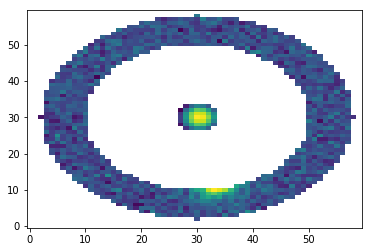

In [95]:
plt.imshow(np.log10(all_masked_boxes[120][0]), aspect='auto', origin='lower')
plt.imshow(np.log10(all_ap_boxes[120][0]), aspect='auto', origin='lower')

In [42]:
#Finding number of pixels in aperture and annulus
annulus_area = []
ap_area = []
for i in range(20):
    annulus_area.append(np.where((all_masked_boxes[i][9] > 3)))

aperture_area = []
for i in range(20):
    aperture_area.append(np.where((all_ap_boxes[i][9] > 3)))
    
#Number of pixels in each annulus
annulus_areas = len(annulus_area[0][0])
aperture_areas = len(aperture_area[0][0])

In [43]:
#Background (annulus) and signal (aperture) noise:
sky_noise_all = [] #Create master empty list for annulus noise
aperture_fluxes_all = [] #Create master empty list for aperture noise
for j in range(0, 363): #Iterate through the 132 files
    sky_all = [] #Create new empty list for annulus noise
    ap_all = [] #Create new empty list for aperture noise
    all_masked_b = all_masked_boxes[j] #Create a variable for the annulus-masked data
    all_masked_a = all_ap_boxes[j] #Create a variable for the aperture-masked data
    for i in range(0, len(new_reference_boxes[j])): #Iterate through the boxes that have been drawn around the reference stars
        sky_all.append(np.sum(all_masked_b[i])/annulus_areas) #Divide the sum of the annulus by the number of pixels in the annuls
        ap_all.append(np.sum(all_masked_a[i])/aperture_areas) #Divide the sum of the aperture by the number of pixels in the aperture
    sky_all = np.array(sky_all) #Turn this into an array
    ap_all = np.array(ap_all) #Turn this into an array
    sky_noise_all.append(sky_all) #Append arrays to master list
    aperture_fluxes_all.append(ap_all) #Append arrays to maser list
sky_noise_all = np.array(sky_noise_all) #Turn this into an array
aperture_fluxes_all = np.array(aperture_fluxes_all) #Turn this into an array

In [44]:
#Subtract sky noise from source
all_reduced_ref = []
for j in range(0, 363):
    red_ref = []
    all_sky = sky_noise_all[j]
    a_flux_all = aperture_fluxes_all[j]
    for i in range(0, len(new_reference_boxes[j])):
        red_ref.append(aperture_areas*a_flux_all[i] - aperture_areas*all_sky[i])
    red_ref = np.array(red_ref)
    all_reduced_ref.append(red_ref)
all_reduced_ref = np.array(all_reduced_ref)

In [45]:
#Finding the position of the target star
t_star_boxes = []
t_starx_postns = [818]
t_stary_postns = [1420]
for i in range(0, 363):
    t_stargpost = []
    for j in range(1):
        t_stargpost.append((masked_final)[i,(t_starx_postns[j]-30):(t_starx_postns[j]+30),(t_stary_postns[j]-30):\
                                          (t_stary_postns[j]+30)])
    t_star_boxes.append(t_stargpost)

In [46]:
#Here the parameters for the targets are found
target_parameters = []
for j in range(0,363):
    t_parameters = []
    for i in range(len(t_starx_postns)):
        t_params = fitgaussian(t_star_boxes[j][i])
        t_parameters.append(t_params)
    target_parameters.append(t_parameters)

In [47]:
#The parameters are then applied to the Gaussian function to output a function
target_fit = []
for j in range(0,363):
    target_fit.append(gaussian(*target_parameters[j][0]))

In [48]:
#The function is then used to find the central point of the star
target_x_pos_all = []
target_y_pos_all = []
#This finds the estimated central point of the star
for j in range(0,363): 
    t_relx_posm = np.where((target_fit[j])(*np.indices(t_star_boxes[j][0].shape))\
                                   ==target_fit[j](*np.indices(t_star_boxes[j][0].shape)).max())[0]
    t_rely_posm = np.where((target_fit[j])(*np.indices(t_star_boxes[j][0].shape))\
                                   ==(target_fit[j])(*np.indices(t_star_boxes[j][0].shape)).max())[1]

    target_x_pos_all.append(t_relx_posm)
    target_y_pos_all.append(t_rely_posm)

In [49]:
#The centre of the target star is then found in term of the overall frame
target_star_centres = []
for j in range(0, 363):
    t_star_centres = []
    t_centres = []
    t_relxs_pos = target_x_pos_all[j]
    t_relys_pos = target_y_pos_all[j]
    for i in range(len(t_starx_postns)):
        t_centres.append(t_relxs_pos[0]+t_starx_postns[i]-30)
        t_centres.append(t_relys_pos[0]+t_stary_postns[i]-30)
        t_star_centres.append(t_centres)
        t_centres=[]
    target_star_centres.append(t_star_centres)
target_star_centres = np.array(target_star_centres)

In [50]:
#Create new boxes with the target star in the centre
target_target_boxes = []
for i in range(0, 363):
    target_target_boxes.append((masked_final)[i,(target_star_centres[i][0][0]-30):(target_star_centres[i][0][0]+30),\
                                              (target_star_centres[i][0][1]-30):(target_star_centres[i][0][1]+30)])

In [51]:
#Calculate annulus for all target stars in all frames
#Centres of boxes:
t_all_box_centres = []
t_all_c_x = []
t_all_c_y = []
for j in range(0, 363):
    #Here we define the arrays and shapes
    t_box_all = target_target_boxes[j]
    t_x_pos = []
    t_y_pos = []
    t_all_box_centres.append(t_box_all.shape)
    #Here we find the x and y positions
    t_all_b_cent = t_all_box_centres[j]
    t_x_pos.append(np.int(t_all_b_cent[0]/2))
    t_y_pos.append(np.int(t_all_b_cent[1]/2))
    #Here we change the x and y positions into arrays
    t_x_pos = np.array(t_x_pos)
    t_y_pos = np.array(t_y_pos)
    #Here is where we load the arrays to the overall lsit
    t_all_c_x.append(t_x_pos)
    t_all_c_y.append(t_y_pos)
t_all_c_x = np.array(t_all_c_x)
t_all_c_y = np.array(t_all_c_y)

In [52]:
#Calculate distances from centre
t_all_height = []
t_all_width = []
t_all_dist_centre = []
t_all_X = []
t_all_Y = []
t_all_grid = []
for j in range(0, 363):
    t_all_b_cent = t_all_box_centres[j]
    t_heights = []
    t_widths = []
    t_grids = []
    t_Xs = []
    t_Ys = []
    t_dist_cent = []
    t_cxs = t_all_c_x[j]
    t_cys = t_all_c_y[j]
    for i in range(0, 1):
        t_heights.append(t_all_b_cent[0]) #Create height values
        t_widths.append(t_all_b_cent[1]) #Create width values
        t_grids.append(np.ogrid[:t_heights[i], :t_widths[i]]) #np.ogrid thing 
        t_Xs.append(grids[i][0]) #Append the x-values of the ogrid
        t_Ys.append(grids[i][1]) #Append the y-values of the ogrid
        t_dist_cent.append(np.sqrt((t_Xs[0] - t_cxs[0])**2 + (t_Ys[0] - t_cys[0])**2)) #Calculate distances from centre
    t_dist_cent = np.array(t_dist_cent)
    t_all_height.append(t_heights)
    t_all_width.append(t_widths)
    t_all_grid.append(t_grids)
    t_all_X.append(t_Xs)
    t_all_Y.append(t_Ys)
    t_all_dist_centre.append(t_dist_cent)
t_all_dist_centre = np.array(t_all_dist_centre)

In [53]:
#Calculate sizes of apertures for target stars
t_ap_size = []
for i in range(0,363):
    t_ap_size.append(len(np.where(target_target_boxes[i][30]>np.std(target_target_boxes[i][30]))[0])/2)

In [54]:
target_aperture_mask = []
target_masks_out = []
target_masks_in = []
for j in range(0, 363):
    t_mask_outs = []
    t_mask_ins = []
    t_aperture_masks  = []
    t_cent = t_all_dist_centre[j]
    for i in range(0, len(t_all_dist_centre[j])):
        t_mask_outs.append(t_cent[i] <= 28)
        t_mask_ins.append(t_cent[i] >= 20)
        t_aperture_masks.append(t_cent[i] < t_ap_size[j])
    t_apertures_masks = np.array(t_aperture_masks)
    t_mask_outs = np.array(t_mask_outs)
    t_mask_ins = np.array(t_mask_ins)
    
    target_aperture_mask.append(t_apertures_masks)
    target_masks_out.append(t_mask_outs)
    target_masks_in.append(t_mask_ins)
    
target_masks_out = np.array(target_masks_out)
target_masks_in = np.array(target_masks_in)
target_aperture_mask = np.array(target_aperture_mask)

#Mask the data with the annulus (Chekc back later to try different radii)
target_masked_boxes = np.zeros_like(target_target_boxes)
for i in range(0, 363):
    target_masked_boxes[i] = target_target_boxes[i]*target_masks_out[i]*target_masks_in[i]

#Find the aperture
target_ap_boxes = np.zeros_like(target_target_boxes)
for i in range(0,363):
    target_ap_boxes[i] = target_target_boxes[i]*target_aperture_mask[i]

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


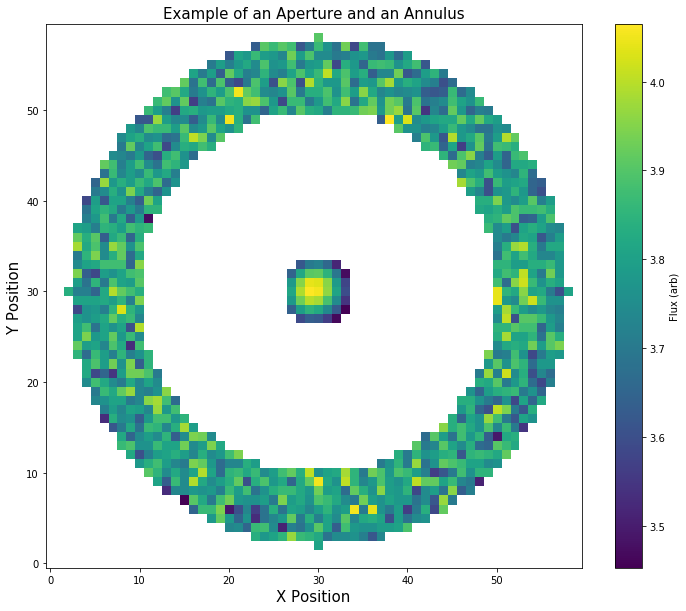

In [98]:
plt.figure(figsize = (12, 10))
plt.imshow(np.log10(target_masked_boxes[0]), aspect='auto', origin='lower')
plt.imshow(np.log10(target_ap_boxes[0]), aspect='auto', origin='lower')
plt.title('Example of an Aperture and an Annulus', fontsize=15)
plt.xlabel('X Position', fontsize=15)
plt.ylabel('Y Position', fontsize=15)
plt.colorbar().set_label('Flux (arb)', rotation=90)
plt.savefig('aperture_phot.pdf')

In [56]:
#Finding number of pixels in aperture and annulus
target_annulus_areas = len(np.where((all_masked_boxes[i][9] > 3))[0])

target_aperture_areas = len(np.where((all_ap_boxes[i][9] > 3))[0])

In [57]:
#Noise reduction process for targets
targets_sky_noise = np.zeros(363)
target_aperture_fluxes = np.zeros(363)
reduced_targets = np.zeros(363)
for i in range(0, 363):
    targets_sky_noise[i] = np.sum(target_masked_boxes[i])/target_annulus_areas
    target_aperture_fluxes[i] = np.sum(target_ap_boxes[i])/target_aperture_areas
    reduced_targets[i] = target_aperture_areas*target_aperture_fluxes[i] - target_aperture_areas*targets_sky_noise[i] 
reduced_targets = np.array(reduced_targets)

In [68]:
#Compute total noise for reference stars
total_noise = aperture_fluxes_all + aperture_areas*(np.mean(sky_noise_all) + np.mean(dark_noise)\
                                                            + np.mean(readout_noise**2)) + aperture_areas*\
(np.mean(sky_noise_all) + np.mean(dark_noise) + np.mean(readout_noise**2))/annulus_areas

In [69]:
#Compute weighted mean of reference star fluxes
fluxes_means = np.zeros(363)
for i in range(0, 363):
    fluxes_means[i] = np.sum(aperture_fluxes_all[i]*total_noise[i])/np.sum(total_noise[i])
    
#Weighted error
fluxes_error = np.zeros(363)
for i in range(0, 363):
    fluxes_error[i] = 1/np.sqrt(np.sum(total_noise[i]))

In [70]:
#Divide the target fluxes by the reference fluxes to get the flux ratio
flux_ratio = np.zeros(363)
for i in range(0, 363):
    flux_ratio[i] = reduced_targets[i]/np.median(reduced_targets)/fluxes_means[i]/np.median(fluxes_means)
    
normalized_ratio = flux_ratio/np.sum(flux_ratio)

normalized_error = np.zeros(363)
for i in range(0, 363):
    normalized_error[i] = normalized_ratio[i]*np.sqrt((fluxes_error[i]/flux_ratio[i])**2 + \
                                                      (np.std(flux_ratio[i])/np.median(flux_ratio))**2)

In [74]:
print(normalized_error)

[52.64229564 52.64163747 52.64136281 52.64182449 52.64121391 52.64148751
 52.64030536 52.64071371 52.64116277 52.63969324 52.64160342 52.64134913
 52.64121024 52.64095932 52.64119828 52.64097449 52.64056115 52.64147596
 52.64106399 52.64152312 52.64185744 52.64183137 52.64179422 52.64233006
 52.6418202  52.64159899 52.64187188 52.64308975 52.64344859 52.64313286
 52.64238267 52.6422133  52.64190217 52.64172412 52.64137443 52.64120449
 52.64070249 52.64097802 52.64103886 52.64162478 52.6410161  52.63924001
 52.64111048 52.6410885  52.64086336 52.64106977 52.64106687 52.64105985
 52.64120846 52.64124653 52.64138135 52.64154386 52.64058177 52.64183813
 52.6414161  52.64104837 52.64111653 52.64151752 52.64173535 52.64131874
 52.64119496 52.64066635 52.64147007 52.64130091 52.64129707 52.64075013
 52.64117408 52.64149157 52.64015107 52.63946688 52.64035456 52.64170155
 52.64183567 52.64087961 52.64027727 52.63893984 52.64115593 52.63903048
 52.64117602 52.6393632  52.64068153 52.63961966 52

Text(0,0.5,'Relative Flux')

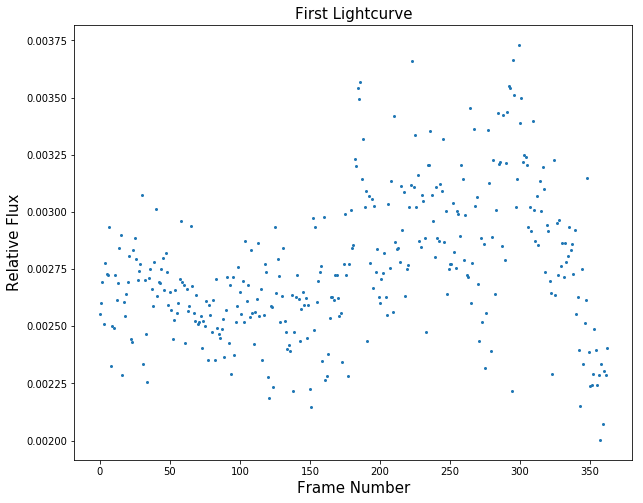

In [72]:
#Plot the lightcurve
plt.figure(figsize=(10,8))
plt.errorbar(np.arange(0, 363), normalized_ratio, xerr=None, yerr=normalized_error, ls='', marker='o', markersize='2')   
plt.title('Lightcurve', fontsize=15)
plt.xlabel('Time (s)', fontsize=15)
plt.ylabel('Relative Flux', fontsize=15)
#plt.ylim(0.94,0.96)
#Multiplied by 10 to bring the ratio to 1 when not eclipsed and less than 1 when eclipsed

#np.arange(0, 0.18403, 0.18403/363)

#Total timesize divided by period, multiply by 2pi, thats how many radians you go through 